In [166]:
%matplotlib inline
# %matplotlib qt 
import matplotlib
matplotlib.use('Qt5Agg')
import itertools as iter
# Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()
from skimage.transform import SimilarityTransform
from skimage.transform import rotate, warp

In [169]:
sample_telemetry = {
    'Path': '/home/dieslow/WORKSPACE/ROBOTZ/RoboND-Rover-Project/collected_images/IMG/robocam_2017_12_06_05_49_10_917.jpg' ,
    'SteerAngle': 0,
    'Throttle': 0,
    'Brake': 0,
    'Speed': 0,
    'X_Position': 140.7583,
    'Y_Position': 108.5207,
    'Pitch': 0.001985437,
    'Yaw': 180.616,
    'Roll': -4.95368E-05
}

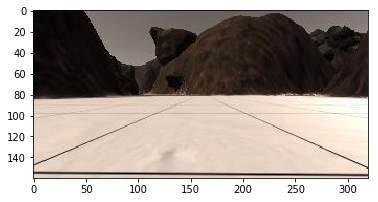

In [3]:
path = '../collected_images/IMG/robocam_2017_12_06_05_49_10_984.jpg'
image = mpimg.imread(path)
plt.imshow(image)

Below seems to produce a slightly rotated transformation look at later if need be

In [ ]:
class NASARover():
    def __init__(self, init_coords, init_yaw):
        self.init_coords = init_coords
        self.init_yaw = init_yaw

        # main map, 10 elements per meter simulation world, estimated necessary size, see below for 
        #  potential expanding version implementation below
#         self.main_map = np.zeros((4000, 4000, 3), dtype=np.int8)
        self.main_map = np.zeros((4000, 4000), dtype=np.int8)
        self.map_origin_coords = (np.int(np.floor(main_map.shape[0] / 2)), np.int(np.floor(main_map.shape[0] / 2)))
        self.image_size = (160, 320)
        self.view_size_x, self.view_size_y = image.shape[:2]
        self.x_half = view_size_x / 2
        self.y_half = view_size_y / 2
        
        self.current_coords = None
        self.current_yaw = None
        
        self.current_view = None
        
        self.rock_locs = None
    
    
    def perspective_transform(self, img, src, dst):           
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
        return warped
    
    def process_image(frame):
        hsv_image = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
        lower_trad_hsv = [10.,0.,75.]     # gpick uses different scale for HSV values than cv2
        upper_trad_hsv = [70.,18.,100.]
        lower_ground = np.array([lower_trad_hsv[0] / 2,(lower_trad_hsv[1] / 100) * 255, (lower_trad_hsv[2] / 100) * 255])
        upper_ground = np.array([upper_trad_hsv[0] / 2,(upper_trad_hsv[1] / 100) * 255, (upper_trad_hsv[2] / 100) * 255])
#         lower_trad_hsv = [5.,5.,40.]
#         upper_trad_hsv = [45.,15.,60.]
#         lower_sky = np.array([lower_trad_hsv[0] / 2,(lower_trad_hsv[1] / 100) * 255, (lower_trad_hsv[2] / 100) * 255])
#         upper_sky = np.array([upper_trad_hsv[0] / 2,(upper_trad_hsv[1] / 100) * 255, (upper_trad_hsv[2] / 100) * 255])
        ground_mask = cv2.inRange(hsv_image, lower_ground, upper_ground).astype(np.bool)
#         sky_mask = cv2.inRange(hsv_image, lower_sky, upper_sky).astype(np.bool)
#         walls_mask = np.bitwise_not(np.bitwise_or(ground_mask, sky_mask))
        ground_out = ground_mask.astype(np.float32)
#         walls_out = walls_mask.astype(np.float32)
        # a lot of this can be moved to an init
        map_grid_side = 10 # each 10x10 pixel sq reps 1 m**2
        dst_size = map_grid_side / 2 
        bottom_offset = 2 # offset to account for bottom space in camera image 
        source = np.float32([[118, 99], [203, 99], [182, 90], [136, 90]])
        destination = np.float32([
            [image.shape[1]/2 - dst_size, image.shape[0] + map_grid_side - bottom_offset],
            [image.shape[1]/2 + dst_size, image.shape[0] + map_grid_side - bottom_offset],
            [image.shape[1]/2 + dst_size, image.shape[0] - map_grid_side - 2*dst_size - bottom_offset], 
            [image.shape[1]/2 - dst_size, image.shape[0] - map_grid_side - 2*dst_size - bottom_offset],
        ])
        ground_warped = self.perspective_transform(ground_out, source, destination)
#         walls_warped = self.perspective_transform(walls_out, source, destination)
        plt.imshow(ground_warped, cmap='gray')

        #scipy.misc.imsave('../output/warped_example.jpg', warped)


    def update_map(main_map, current_view, current_coords):
        # angle subtraction may be tricky
        yaw_diff = self.init_yaw - self.current_yaw
        transed = transform.rotate(ground_warped, angle=yaw_diff, resize=False, center=(160, 160), order=1, mode='constant', cval=0, clip=True, preserve_range=True)

#         # add walls to current_map section
#         self.main_map[:,:,1][current_coords[0]-x_half:
#                         current_coords[0]+x_half, current_coords[1]:current_coords[1]+y_half*2] = np.bitwise_or(
#             self.main_map[:,:,1][current_coords[0]-x_half:current_coords[0]+x_half, current_coords[1]:
#                             current_coords[1]+y_half*2], walls_warped.astype(np.int8))

        # add path to current map section
        self.main_map[:,:,0][current_coords[0]-x_half:
                        current_coords[0]+x_half, current_coords[1]:current_coords[1]+y_half*2] = np.bitwise_or(
            self.main_map[:,:,0][current_coords[0]-x_half:current_coords[0]+x_half, current_coords[1]:
                            current_coords[1]+y_half*2], ground_warped.astype(np.int8))

        plt.imshow(self.main_map[current_coords[0]-x_half:current_coords[0]+x_half, 
                                 current_coords[1]:current_coords[1]+y_half*2])
  
    def make_decision_for_next_point_state_machine():
        pass
    def create_control_inputs_for_next_cycle():
        pass

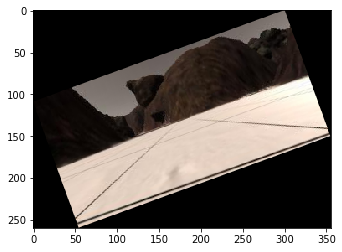

In [147]:
transed = transform.rotate(image, angle=20, resize=True, center=(160, 160), order=1, mode='constant', cval=0, clip=True, preserve_range=False)
plt.imshow(transed)

# BIG TODO: NEED TO TAKE INTERSECTION OF TWO AND PREFER PATH WHERE THERES OVERLAP


# THIS ABOVE NEEDS TO BE VERIFIED AGAINST BOTH AND OVERHEAD SHOT FROM THE SIM, AS WELL AS IN OTHER, LESS SPACIOUS CONDITIONS

# TODO: Take a second threshold with the colors of the rocks, to create blocked areas|

In [164]:
# tform = SimilarityTransform(translation=(0, -10))
# awarped = warp(image, tform)
# plt.imshow(awarped)

# coordinate_shift_dict = {(k, None) for k in list(iter.product(range(0, 160), range(-160,160)))}
# transform.s
# plt.imshow(transed, cmap='gray')
# for k, v in coordinate_shift_dict.items():
#     # map image to rover coordinates (assuming camera is 0, which is doesn't appear to be)
#     v = (k[0] + current_coords[0], k[1] + current_coords[1]) 
#     # don't need to translate these coords to global map
    

In [ ]:
def make_decision_for_next_point_state_machine():
    if not stopped:
        if wall within stopping distance:
            stop or (not likely) tight turn
        else: 
            create a random number between 0 and 2pi 
            find corresponding vector n meters away 
            checkk if vector is in wall and if so reguess
            otherwise accept with a probability related to the dot product of that vector and current trajectory vector
            take point along vector much closer to rover
            turn that many degrees either at once or over a few frames
    else: 
        do same thing for else above but maybe with large n meter parameter
        but then turn in place and then need to accelerate to speed
    pass

In [ ]:
def create_control_inputs_for_next_cycle():
    pass

In [ ]:
class MappingMap(np.ndarray):
    __init__():
        pass

In [ ]:
class ExpandingMap(object):
    def __init__(self, np_arr):
        self._array = np.array(np_arr)
        maybe_initialize_a_map_with_neg_1s_and_shit
    def __add__(self, other_np_array, addition_point):
        if addition_point + other_np_array_dims_y > self_arr_dims:
            create_a_new_larger_array_of_size
            set_array_to_be_so_and_so
        return np.add(self._array, other_np_array)
    def maybe_no_add_just_expand_map_by_matching

In [ ]:
def hsv_color_select(frame):
    hsv_image = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    lower_trad_hsv = [10.,0.,75.]
    upper_trad_hsv = [70.,18.,100.]
    # gpick uses different scale for HSV values than cv2
    lower_ground = np.array([lower_trad_hsv[0] / 2,(lower_trad_hsv[1] / 100) * 255, (lower_trad_hsv[2] / 100) * 255])
    upper_ground = np.array([upper_trad_hsv[0] / 2,(upper_trad_hsv[1] / 100) * 255, (upper_trad_hsv[2] / 100) * 255])

    lower_trad_hsv = [5.,5.,40.]
    upper_trad_hsv = [45.,15.,60.]
    lower_sky = np.array([lower_trad_hsv[0] / 2,(lower_trad_hsv[1] / 100) * 255, (lower_trad_hsv[2] / 100) * 255])
    upper_sky = np.array([upper_trad_hsv[0] / 2,(upper_trad_hsv[1] / 100) * 255, (upper_trad_hsv[2] / 100) * 255])
    
    ground_mask = cv2.inRange(hsv_image, lower_ground, upper_ground).astype(np.bool)
    sky_mask = cv2.inRange(hsv_image, lower_sky, upper_sky).astype(np.bool)
    walls_mask = np.bitwise_not(np.bitwise_or(ground_mask, sky_mask))
    return ground_mask.astype(np.float32), walls_mask.astype(np.float32)

ground_masked, walls_masked = hsv_color_select(image)

plt.imshow(walls_masked, cmap='gray')

In [ ]:
def perspect_transform(img, src, dst):           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    return warped

# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
map_grid_side = 10
dst_size = map_grid_side / 2 
# Set a bottom offset to account for the fact that the bottom of the image 
bottom_offset = 2
source = np.float32([[118, 99], [203, 99], [182, 90], [136, 90]])
destination = np.float32([
    [image.shape[1]/2 - dst_size, image.shape[0] + map_grid_side - bottom_offset],
    [image.shape[1]/2 + dst_size, image.shape[0] + map_grid_side - bottom_offset],
    [image.shape[1]/2 + dst_size, image.shape[0] - map_grid_side - 2*dst_size - bottom_offset], 
    [image.shape[1]/2 - dst_size, image.shape[0] - map_grid_side - 2*dst_size - bottom_offset],
])
# warped = perspect_transform(threshed, source, destination)
ground_warped = perspect_transform(ground_masked, source, destination)
walls_warped = perspect_transform(walls_masked, source, destination)

plt.imshow(ground_warped, cmap='gray')
# plt.imshow(walls_warped, cmap='gray')
#scipy.misc.imsave('../output/warped_example.jpg', warped)